In [172]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
# import os
# import sqlalchemy
# from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
# import alloc_functions.allocation_scenario as asf
# import alloc_functions.controller as acf
# import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib
import json
from pulp import *
FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']
# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

## Create routes and vehicle duties

In [149]:
def read_routes(comment):
    try:
        cnx = dbh.create_alch_engine()
        sql_query = f"""SELECT route_id, actual_start_time, actual_end_time, number_order,
            distance_miles, site_id_start, site_id_end, vehicle_id FROM t_route_formatted
            WHERE comment = '{comment}'"""
        routes = pd.read_sql_query(sql_query, cnx)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching telematics")
        raise error
    finally:
        cnx.dispose
    # TODO Check datatypes
    return routes

def get_site_name_dict(client):
    try:
        connection, cur = dbh.database_connection('test')
        sql_query = f"""SELECT site_id, site_name
            FROM t_sites WHERE client_id={client}"""
        cur.execute(sql_query)
        connection.commit()
        site_data = cur.fetchall()
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching site data")
        raise error
    finally:
        cur.close()
        connection.close()
    site_name_dict = {site[0]: site[1]
                       for site in site_data}
    return site_name_dict

# site_id starts
def bar_plot_site_starts(routes, site_dict, site=0):
    grouped = routes.groupby(['site_id_start', 'same_return'])['route_id'].count().unstack(fill_value=0)
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    grouped['n_routes'] = grouped[True] + grouped[False]
    grouped = grouped.sort_values(by='n_routes', ascending=False).reset_index()
    grouped = grouped[grouped['n_routes'] > 5]

    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Vehicles asigned to {site_dict[site]} \n Where do routes start?',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index,
        height=grouped[True],
        color=[fps_colours[0]], label='Same return site')
    ax.bar(
        x=grouped.index,
        height=grouped[False], bottom=grouped[True],
        color=[fps_colours[1]], label='Different return site')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    # ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=f'{len(routes)} Routes')
    n_same_start = sum(routes['start_right_id'])
    ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=(
        f"{len(routes)} Routes\n"
        f"{np.round(100*n_same_start/len(routes), 1)}% start on the right site\n"
        f"{np.round(100*routes['same_return'].mean(), 1)}% return to same site"
        ))
    fig.savefig(
        f"sample/hgv2/{site_dict[site]}_site_starts.png",
        bbox_inches="tight", dpi=300)
    return

def bar_plot_site_ends(routes, site_dict, site, suff='', ):
    grouped = routes.groupby(['site_id_end', 'start_right_id'])['route_id'].count().unstack(fill_value=0)
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    for c in [True, False]:
        if c not in grouped.columns:
            grouped[c] = 0
    grouped['n_routes'] = grouped[True] + grouped[False]
    grouped = grouped.sort_values(by='n_routes', ascending=False).reset_index()
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Routes starting from {site_dict[site]} \n Where do routes end?',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index,
        height=grouped[True],
        color=[fps_colours[0]], label=f'Originally from {site_dict[site]}')
    ax.bar(
        x=grouped.index,
        height=grouped[False], bottom=grouped[True],
        color=[fps_colours[1]], label=f'Originally NOT from {site_dict[site]}')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    ax.text(x=len(grouped)+2, y=grouped['n_routes'].max()/2, s=(
        f"{len(routes)} Routes\n"
        f"{np.round(100*routes['start_right_id'].mean(), 1)}% originally from site\n"
        f"{np.round(100*routes['same_return'].mean(), 1)}% return to same site"
        ))
    fig.savefig(
        f"sample/hgv2/{site_dict[site]}_site_ends{suff}.png",
        bbox_inches="tight", dpi=300)
    return

def right_start_site(start_id, site):
    return start_id in site

def histo_variable(df, colname, site_dict, site=0, upperclip=None, lowerclip=None, bins=10,
                   suff='', vline_dict=None, title_text=None):
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    if title_text is None:
        title_text = site_dict[site]
    ax.set_title(
        f'{title_text} \n {colname} distribution',
        color=fps_colours[0], fontweight='bold')
    r = ax.hist(
        df[colname].clip(upper=upperclip, lower=lowerclip),
        color=[fps_colours[0]],
        bins=bins)

    ax.set_ylabel('# of routes', color=fps_colours[0])
    ax.set_xlabel(f'{colname}', color=fps_colours[0])
    ax.text(x=r[1][-1]*1.1, y=r[0].max()/2, s=(
        f"{len(df)} entries\n"
        f"Mean: {np.round(df[colname].mean(), 1)}\n"
        f"Max: {np.round(df[colname].max(), 1)}\n"
        f"{np.round((df[colname] > upperclip).mean()*100, 1)}% over threshold {upperclip}\n"
        f"{np.round((df[colname] < lowerclip).mean()*100, 1)}% under threshold {lowerclip}"
        ))
    if vline_dict:
        for i, key in enumerate(vline_dict.keys()):
            ax.axvline(x=vline_dict[key], label=key,
                       color=fps_colours[(i+1)%len(fps_colours)])
        ax.legend(frameon=False)
    fig.savefig(
        f"sample/hgv2/{site_dict[site]}_histo_{colname}{suff}.png",
        bbox_inches="tight", dpi=300)
    return

def read_telematics(runs, con):
    COLS = ['departure_time', 'departure_location', 'arrival_time',
        'arrival_location', 'distance_miles', 'driving_time',
        'vehicle_id', 'journey_node_id', 'route_id', 'run', 'client_id',
        'departure_site_id', 'arrival_site_id', 'site_id']
    try:
        cols_telematics = ", ".join(COLS)
        sql_query = f"""SELECT {cols_telematics} FROM t_telematics
            WHERE run IN {runs}"""
        telematics = pd.read_sql_query(sql_query, con)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching telematics")
        raise error
    # TODO Check datatypes
    # telematics['distance_miles'] = telematics['distance_miles'].clip(lower=0)
    return telematics

def bar_plot_vehicle_sites(routes, site_dict, site_veh_count):
    grouped = routes.groupby(['site_id_start', 'vehicle_id']).count()[['route_id', 'distance_miles']]
    grouped = grouped.groupby('site_id_start').count()
    grouped['site_name'] = grouped.index.map(site_dict).fillna('other')
    grouped = grouped.merge(site_veh_count, left_index=True, right_index=True, how='left')
    grouped = grouped.reset_index()
    # print(grouped.head())
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Vehicle locations',
        color=fps_colours[0], fontweight='bold')
    ax.bar(
        x=grouped.index-0.2,
        height=grouped['route_id'], width=0.5,
        color=[fps_colours[0]], label='According to route starts')
    ax.bar(
        x=grouped.index,
        height=grouped['vehicle_id'], width=0.5,
        color=[fps_colours[1]], label='According to microlise groups')

    ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
    ax.set_ylabel('# of vehicles', color=fps_colours[0])
    ax.set_xlabel('Site', color=fps_colours[0])
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(len(grouped))))
    ax.set_xticklabels(grouped['site_name'], rotation=45, ha='right')
    n_veh = len(routes['vehicle_id'].unique())
    ax.text(x=len(grouped)+2, y=grouped['route_id'].max()/2,
            s=f'{n_veh} vehicles in total')
    fig.savefig(
        f"sample/hgv2/where_vehicles_work.png",
        bbox_inches="tight", dpi=300)
    return

def violin_plot(distribution_array, variable, site_name, labels=None, suff=""):
    fig, ax = plt.subplots(
        1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'How many {variable} return to site?',
        color=fps_colours[0], fontweight='bold')
    N = len(labels)
    r = ax.violinplot(distribution_array)
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(1, N+1)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(f'% of {variable} returning to site', color=fps_colours[0])
    ax.set_xlabel("Type of vehicle", color=fps_colours[0])

    fig.savefig(
        f"sample/hgv2/{site_name}_violin{suff}.png",
        bbox_inches="tight", dpi=300)
    return r


### Tidy routes

In [ ]:
comment = "HGV repated 2022-05-31 10:23"
routes = read_routes(comment)
routes.sort_values(by='actual_start_time', inplace=True)
site_dict = get_site_name_dict(2)
site_dict[0] = 'All Sites'
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
crick_entries = sheet_list['site_id'] == 304
sheet_list.loc[crick_entries, 'site_id'] = 13
site_veh_count = sheet_list.groupby('site_id')['vehicle_id'].count()
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False

for idx in routes.index:
    routes.loc[idx, 'start_right_id'] = right_start_site(
        routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])
other_sites = [27, 29, 30, 31, -9999]
routes = routes[~routes['site_id_start'].isin(other_sites)]
routes['duration_hours'] = (routes['actual_end_time'] - routes['actual_start_time']).dt.total_seconds()/3600
routes['date'] = routes['actual_start_time'].dt.date
routes['start_time'] = (routes['actual_start_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['actual_end_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
duty_wait_time = dt.timedelta(hours=6)
cleaned_routes = routes[
    (routes['duration_hours'] <= 10)
    & (routes['distance_miles'] <= 400)].copy()
cleaned_routes.sort_values(by=['vehicle_id', 'actual_start_time'],
                        inplace=True)
cleaned_routes['prev_wait_time'] = (cleaned_routes['actual_start_time']
                                    - cleaned_routes['actual_end_time'].shift(1))
cleaned_routes['client_id'] = 3
cleaned_routes['source'] = 1
cleaned_routes['new_vehicle'] = cleaned_routes['vehicle_id'] != cleaned_routes['vehicle_id'].shift(1)
cleaned_routes['new_duties'] = ((cleaned_routes['new_vehicle'])
                                | (cleaned_routes['prev_wait_time'] > duty_wait_time))
cleaned_routes['duty_id'] = cleaned_routes['new_duties'].cumsum()
cleaned_routes.rename(columns={'actual_start_time': 'departure_time', 'actual_end_time': 'arrival_time'}, inplace=True)
daily_duties = cleaned_routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'last',
    'route_id': 'count'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'duration_hours', 'number_order', 'arrival_time', 'n_routes']
cols = ['client_id', 'route_id', 'site_id_start', 'departure_time', 'arrival_time', 'vehicle_id',
        'distance_miles', 'number_order', 'site_id_end', 'source']
dbh.upload_table(cleaned_routes[cols], 't_route_master')

### Fix vehicle specs

In [136]:
# hgv_assets = pd.read_csv(r"C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\22-03.SSL.depot_asset_register.MA.02.csv",
#                          usecols=['Fleet Reg No', 'spec_id'])
# # hgv_spec_dict = hgv_assets['spec_id'].to_dict()
cnx = dbh.create_alch_engine()
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
# weird_float_str = vehicle_df['client_vehicle_id'].str[-2:] == ".0"
# vehicle_df.loc[weird_float_str, 'client_vehicle_id'] = vehicle_df.loc[weird_float_str, 'client_vehicle_id'].str[:4]
# vehicle_df['spec_id'] = vehicle_df['client_vehicle_id'].map(hgv_spec_dict)
# vehicle_df['spec_id'] = vehicle_df['spec_id'].fillna(0).astype(int)
# vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
# dbh.upload_table(vehicle_df.reset_index(), 't_vehicles')

### Filter vehicle types

In [137]:
# cnx = dbh.create_alch_engine()
site_dict = get_site_name_dict(2)
site = 1
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
routes = pd.read_sql_query(sql_query, con=cnx)
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
good_specs = {100: 'trailers',
              101: '4x2 rigid',
              102: '6x2 rigid',
              103: '4x2 tractor',
              104: '6x2 tractor'}
routes = routes[routes['spec_id'].isin(good_specs.keys())].copy()

In [138]:
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24


for idx in routes.index:
    routes.loc[idx, 'start_right_id'] = right_start_site(
        routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])

# for spec in good_specs:
#     spec_routes = routes[routes['spec_id'] == spec]
#     bar_plot_site_ends(spec_routes, site_dict, site, suff=str(spec))

spec_stats = 100*routes.groupby('spec_id')[['same_return']].mean().round(3)
spec_stats['vehicle_type'] = spec_stats.index.map(good_specs)

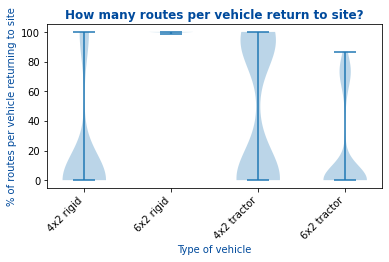

In [157]:
site_routes = routes[routes['site_id_start'] == site]
vehicle_return_pc = 100*site_routes.groupby(['spec_id', 'vehicle_id'])['same_return'].mean()
vehicle_high_return = vehicle_return_pc > 95
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    array_return_pc.append(vehicle_return_pc.loc[s].values)
    labels.append(good_specs[s])
violin_plot(array_return_pc, "routes per vehicle", site_dict[site], labels=labels, suff="_routes")
for spec in good_specs:
    spec_routes = site_routes[(site_routes['spec_id'] == spec) & (site_routes['site_id_end'] == site)]
    # histo_variable(spec_routes, 'duration_hours', site,
    #                upperclip=400, bins=20, suff=spec, title_text=good_specs[spec])

### Daily duties

% duties returning to site: 0.9828687967369136
0.7135135135135136


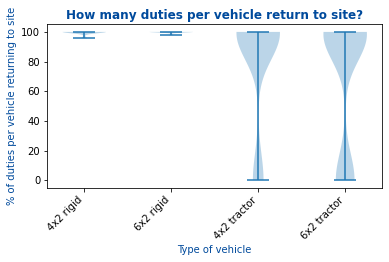

In [160]:
duty_wait_time = dt.timedelta(hours=4)
routes.sort_values(by=['vehicle_id', 'departure_time'],
                        inplace=True)
routes['prev_wait_time'] = (routes['departure_time'] - routes['arrival_time'].shift(1))
routes['new_vehicle'] = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes['new_duties'] = ((routes['new_vehicle']) | (routes['prev_wait_time'] > duty_wait_time))
routes['duty_id'] = routes['new_duties'].cumsum()

daily_duties = routes.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'number_order', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']#
daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600
daily_duties_site = daily_duties[(daily_duties['site_id_start'] == site)
                                 & (daily_duties['spec_id'] > 100)]
spec_stats_duty = 100*daily_duties_site.groupby('spec_id')[['same_return']].mean().round(3)
vehicle_return_duty_pc = daily_duties_site.groupby(['spec_id', 'vehicle_id']).agg({'same_return': 'mean', 'date': 'nunique'})
vehicle_high_return = ((vehicle_return_duty_pc['same_return'] > 0.95)
                       & (vehicle_return_duty_pc['date'] > 20))
array_return_pc = []
labels = []
for s in [101, 102, 103, 104]:
    array_return_pc.append(100*vehicle_return_duty_pc.loc[s, 'same_return'].values)
    labels.append(good_specs[s])
violin_plot(array_return_pc, "duties per vehicle", site_dict[site], labels=labels, suff="_duties")
print(f"% duties returning to site: {daily_duties_site['same_return'].mean()}")
print(vehicle_high_return.mean())

### Filter vehicle duties and routes

In [ ]:
vehicles_to_use = vehicle_high_return[vehicle_high_return].index.get_level_values(1)
duties_site_return = daily_duties[(daily_duties['site_id_start'] == site)
                                #   & (daily_duties['site_id_end'] == site)
                                  & (daily_duties['vehicle_id'].isin(vehicles_to_use))].copy()
# histo_variable(duties_site_return, 'duty_duration', site,
#                 upperclip=400, bins=20, suff=spec, title_text=site)
cols_routes = ['site_id_start', 'departure_time', 'arrival_time',
       'vehicle_id', 'distance_miles', 'route_id', 'site_id_end', 'spec_id',
       'duration_hours', 'date', 'start_time', 'end_time', 'prev_wait_time',
       'new_duties', 'duty_id']
routes_vehicle_selection = routes[routes['vehicle_id'].isin(vehicles_to_use)][cols_routes].copy()
duties_vehicle_selection = daily_duties[daily_duties['vehicle_id'].isin(vehicles_to_use)]

In [ ]:
# This creates new breakpoints in the vehicle duties based on the longest break time back on the site

duty_hour_threshold = 25
duty_hour_min = dt.timedelta(hours=24)
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))
duty_route_cols = ['site_id_start', 'prev_wait_time', 'new_duties', 'departure_time']
for duty in long_duties[:]:
    duty_routes = routes_vehicle_selection[routes_vehicle_selection['duty_id'] == duty][duty_route_cols]
    elapsed_time = duty_routes['departure_time'] - duty_routes['departure_time'].min()
    time_difference = (elapsed_time - duty_hour_min).dt.total_seconds().abs()
    possible_break_routes = ((duty_routes['site_id_start'] == site)
               & (~duty_routes['new_duties']))

    break_route = time_difference.loc[possible_break_routes].idxmin()
    routes_vehicle_selection.loc[break_route, 'new_duties'] = True

routes_vehicle_selection['duty_id'] = routes_vehicle_selection['new_duties'].cumsum()

duties_vehicle_selection = routes_vehicle_selection.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})

duties_vehicle_selection.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']

duties_vehicle_selection['duty_duration'] = (duties_vehicle_selection['arrival_time'] - duties_vehicle_selection['departure_time']).dt.total_seconds()/3600
long_duties = duties_vehicle_selection[duties_vehicle_selection['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(duties_vehicle_selection))

duties_vehicle_selection['same_return'] = duties_vehicle_selection['site_id_start'] == duties_vehicle_selection['site_id_end']
daily_duties_site = duties_vehicle_selection[
    (duties_vehicle_selection['site_id_start'] == site)
    & (duties_vehicle_selection['site_id_end'] == site)
    & (duties_vehicle_selection['spec_id'] > 100)]
# import pickle
# dtstring = str(dt.datetime.now())[:16]
# pickle.dump(daily_duties_site, open(f'sample/hgv2/daily_duties_site_{dtstring}.pkl', 'wb'))
# pickle.dump(routes_vehicle_selection, open(f'sample/hgv2/routes_vehicle_selection_{dtstring}.pkl', 'wb'))

### Upload to db

In [ ]:
sql_query = """SELECT spec_id, vehicle_model, fuel_type, quoted_range_mile, energy_use, battery_size, charge_power_ac, charge_power_dc
    FROM t_vehicle_specification
    WHERE vehicle_category = 'hgv'
    ORDER BY spec_id"""
hgv_specs = pd.read_sql_query(sql_query, con=cnx, index_col='spec_id')
hgv_drive = hgv_specs['energy_use'].to_dict()

In [ ]:
spec, allocation_id = 101, 414
# spec, allocation_id = 102, 415
# spec, allocation_id = 103, 416
# spec, allocation_id = 104, 417

duties_spec = daily_duties_site[daily_duties_site['spec_id'] == spec]
cols_routes = ['duty_id', 'route_id', 'date', 'spec_id', 'distance_miles', 'vehicle_id']
routes_spec = routes_vehicle_selection[routes_vehicle_selection['duty_id'].isin(duties_spec.index)][cols_routes]
# routes_spec.reset_index(inplace=True)
routes_spec.columns = ['duty_id', 'route_id', 'date', 'allocated_spec_id', 'distance_miles', 'allocated_vehicle_id']
routes_spec['allocation_id'] = allocation_id
routes_spec['shift'] = 1
routes_spec['diesel_fuel_consumption'] = routes_spec['distance_miles'] * hgv_drive[spec]
routes_spec.drop(columns=['distance_miles'], inplace=True)
dbh.upload_table(routes_spec, 't_route_allocated')

## Feasibility Analysis

### Allocation

In [169]:
# Create vehicle specification table

specs = tuple(np.arange(101, 111))
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']

In [170]:
connection, cur = dbh.database_connection('test')

In [171]:
# allocation, new_allocation, ev_spec = 414, 418, 105
allocation, new_allocation, ev_spec = 415, 419, 106
# allocation, new_allocation, ev_spec = 416, 420, 107
# allocation, new_allocation, ev_spec = 417, 421, 108
# allocation, new_allocation, ev_spec = 416, 422, 109
# allocation, new_allocation, ev_spec = 416, 423, 110

alloc = ff.find_allocation(allocation)
routes, grouped = ff.allocation_grouping(
    alloc,
    vehicle_specifications.loc[ev_spec, 'energy_use'],
    # 2.903225806451613,
    vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
    vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
    # 150,
    connection, cur)
ff.calculate_feasibility(grouped, vehicle_specifications.loc[ev_spec, 'quoted_range_mile'])
# ff.calculate_feasibility(grouped, 186)
ev_vehicle_map = ff.ev_feasibility_dict(grouped, ev_spec)
grouped['allocated_spec_id'] = grouped['allocated_vehicle_id'].map(ev_vehicle_map)
routes['allocated_spec_id'] = routes['allocated_vehicle_id'].map(ev_vehicle_map)
# ff.upload_ev_routes(routes,
#                  vehicle_specifications['kwh_mile'].to_dict(),
#                  vehicle_specifications['diesel_l_mile'].to_dict(),
#                  new_allocation)
# number_dc = grouped.groupby('date').sum()['feasible_withdc'].max()
# feasibility_count = grouped[['feasible_nois', 'feasible_withac', 'feasible_withdc', 'unfeasible_withdc']].sum()
# new_alloc = ff.upload_new_allocation(alloc, new_allocation, routes, ev_vehicle_map,
#                                   vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
#                                   vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
#                                   number_dc, feasibility_count, connection, cur)

In [172]:
routes

,duty_id,date,distance_miles,allocated_vehicle_id,allocated_spec_id
route_id,,,,,
1046889,7259,2022-02-12,12.927284,2373,102.0
1046890,7260,2022-02-12,86.954630,2373,102.0
1046891,7261,2022-02-13,2.883779,2373,102.0
1046892,7262,2022-02-13,51.118707,2373,102.0
1046893,7263,2022-02-14,54.953387,2373,102.0
...,...,...,...,...,...
1176549,9162,2022-04-26,21.466750,9095,106.0
1176550,9162,2022-04-26,5.208204,9095,106.0
1176551,9163,2022-04-26,0.702300,9095,106.0


In [19]:
grouped.groupby('allocated_vehicle_id').mean()

,site_id_start,number_sites,distance_miles,route_hours,n_routes,site_id_end,allocated_spec_id,start_time,end_time,same_return,...,TPs,extra_mileage_ac,extra_mileage_dc,reduced_mileage_ac,reduced_mileage_dc,feasible_nois,feasible_withac,feasible_withdc,unfeasible_withdc,ev_possible
allocated_vehicle_id,,,,,,,,,,,,,,,,,,,,,
2373.0,1.0,1.0,49.380588,6.044623,1.586538,1.0,102.0,9.796146,15.055756,1.0,...,2.625000,24.657628,143.358300,41.630819,41.157671,0.884615,0.057692,0.000000,0.057692,0.942308
9087.0,1.0,1.0,52.618354,6.160115,1.637931,1.0,106.0,9.001183,15.085333,1.0,...,2.655172,24.941049,145.006096,42.538640,40.700575,0.836207,0.094828,0.034483,0.034483,0.965517
9088.0,1.0,1.0,54.031160,6.204438,1.681818,1.0,106.0,9.566976,13.041465,1.0,...,3.363636,31.595921,183.697215,42.829006,41.600938,0.863636,0.090909,0.045455,0.000000,1.000000
9089.0,1.0,1.0,42.322966,6.420414,1.693878,1.0,102.0,9.055414,15.317888,1.0,...,3.102041,29.138654,169.410780,34.593742,34.090067,0.887755,0.051020,0.000000,0.061224,0.938776
9090.0,1.0,1.0,40.598785,5.368550,1.495798,1.0,106.0,9.980138,15.537635,1.0,...,2.159664,20.286547,117.945044,34.368039,33.349385,0.899160,0.058824,0.025210,0.016807,0.983193
9091.0,1.0,1.0,51.074444,6.263604,1.670732,1.0,106.0,9.516409,15.191609,1.0,...,2.890244,27.149165,157.843981,42.056637,41.407100,0.853659,0.109756,0.012195,0.024390,0.975610
9092.0,1.0,1.0,47.364339,6.311750,1.733333,1.0,106.0,8.887975,16.075386,1.0,...,3.266667,30.685048,178.401439,37.278689,36.285339,0.877778,0.077778,0.011111,0.033333,0.966667
9093.0,1.0,1.0,51.201817,6.486738,1.723404,1.0,106.0,8.784512,16.440328,1.0,...,3.191489,29.978878,174.295805,42.098590,41.330217,0.872340,0.063830,0.021277,0.042553,0.957447
9094.0,1.0,1.0,43.050537,5.888280,1.617978,1.0,106.0,9.526096,15.779254,1.0,...,2.741573,25.752643,149.724666,35.399209,34.945007,0.910112,0.056180,0.011236,0.022472,0.977528


(array([350., 175., 205.,  72.,  79.,  38.,   9.,   8.,   1.,   1.]),
 array([1.24300808e-01, 1.87576134e+01, 3.73909260e+01, 5.60242387e+01,
        7.46575513e+01, 9.32908639e+01, 1.11924177e+02, 1.30557489e+02,
        1.49190802e+02, 1.67824114e+02, 1.86457427e+02]),
 <BarContainer object of 10 artists>)

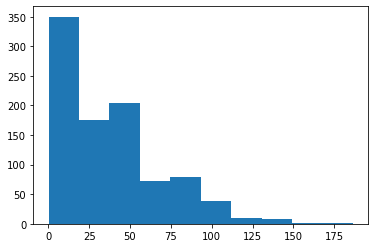

In [13]:
plt.hist(grouped['reduced_mileage_dc'])

### Feasibility plots

In [110]:
cnx = dbh.create_alch_engine()
sql_query = """SELECT allocation_id, charger1, charger2, vehicle1, vehicle2,
    num_vehicle1, num_vehicle2, num_r, xmpg,
    n_duties, n_feas_nois, n_feas_withis, n_unfeas, n_r_rem
    FROM t_allocation
    WHERE allocation_id >= 414"""
allocation_table = pd.read_sql_query(sql_query, con=cnx)
allocation_tuple = tuple(allocation_table['allocation_id'].values)
sql_query = f"SELECT scenario_id, allocation_id, smart_charging, num_charger1, num_charger2 FROM t_charging_scenarios WHERE allocation_id IN {allocation_tuple}"
scenarios = pd.read_sql_query(sql_query, con=cnx)
scenarios = scenarios.merge(allocation_table, how='left', left_on='allocation_id', right_on='allocation_id')
scenarios.sort_values(by='allocation_id', inplace=True)
scenarios = scenarios.merge(vehicle_specifications, how='left', left_on='vehicle1', right_on='spec_id')
scenarios['total_vehicles'] = scenarios['num_vehicle1'] + scenarios['num_vehicle2']
scenarios.set_index('scenario_id', inplace=True)
scenarios['good_scenario'] = False
scenarios.loc[[510, 511, 512, 513, 516, 517], 'good_scenario'] = True
scenarios['non_diversified_load'] = (scenarios['num_charger1'] * scenarios['charger1']
                                     + scenarios['num_charger2'] * scenarios['charger2'])
# scenarios.to_csv('sample/hgv2/scenarios.csv')

In [114]:
scenarios[['allocation_id', 'n_duties', 'n_feas_nois', 'n_feas_withis', 'n_unfeas', 'n_r_rem',
           'vehicle_model', 'fuel_type', 'num_vehicle1', 'total_vehicles']]

,allocation_id,n_duties,n_feas_nois,n_feas_withis,n_unfeas,n_r_rem,vehicle_model,fuel_type,num_vehicle1,total_vehicles
scenario_id,,,,,,,,,,
500,414,716,716,0,0,0,Rigid 4x2,diesel,8,8
501,415,938,938,0,0,0,Rigid 6x2,diesel,10,10
502,416,2777,2777,0,0,0,Tractor 4x2,diesel,41,41
503,417,5161,5161,0,0,0,Tractor 6x2,diesel,73,73
504,418,716,695,19,2,0,Rigid 4x2,electric,8,8
510,418,716,695,19,2,0,Rigid 4x2,electric,8,8
494,418,716,695,19,2,0,Rigid 4x2,electric,8,8
495,419,938,829,78,31,0,Rigid 6x2,electric,8,10
511,419,938,829,78,31,0,Rigid 6x2,electric,8,10


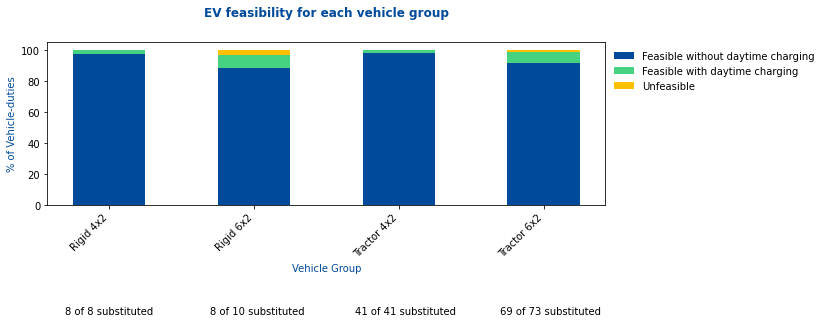

In [92]:
fig, ax = plt.subplots(1, figsize=(10, 3))
allocations = [418, 419, 420, 421]
group = 'electric'
# allocations = [420, 422, 423]
# group = '4x2tractor'


cols = ['n_feas_nois', 'n_feas_withis', 'n_unfeas', 'n_duties', 'num_vehicle1', 'total_vehicles']
scenarios_vehicle = scenarios[scenarios['allocation_id'].isin(allocations)][cols].values
xlabels = scenarios[scenarios['allocation_id'].isin(allocations)]['vehicle_model'].values
N = len(xlabels)
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 0]*100/scenarios_vehicle[:, 3],
    width=0.5,
    color=[fps_colours[0]], label='Feasible without daytime charging')
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 1]*100/scenarios_vehicle[:, 3],
    bottom=scenarios_vehicle[:, 0]*100/scenarios_vehicle[:, 3],
    width=0.5,
    color=[fps_colours[1]], label='Feasible with daytime charging')
ax.bar(x = xlabels,
    height=scenarios_vehicle[:, 2]*100/scenarios_vehicle[:, 3],
    width=0.5,
    bottom=(scenarios_vehicle[:, 0] + scenarios_vehicle[:, 1])*100/scenarios_vehicle[:, 3],
    color=[fps_colours[2]], label='Unfeasible')
ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.set_xlabel('Vehicle Group', color=fps_colours[0])
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(np.arange(N)))
ax.set_xticklabels(xlabels, rotation=45, ha='right')
ax.set_ylabel(r'% of Vehicle-duties', color=fps_colours[0])
for i in range(N):
    ax.text(i-0.3, -70,
            f"{scenarios_vehicle[i, 4]} of {scenarios_vehicle[i, 5]} substituted")
ax.set_title(
    f"EV feasibility for each vehicle group",
    color=fps_colours[0], fontweight='bold', y=1.12)
fig.savefig(
    f"sample/hgv2/feasibility_alloc{group}.png",
    bbox_inches="tight", dpi=300)

## Charging

### Charging profiles

In [171]:
TIME_FRACT = 0.5
ASC_XUSE = 0.9
CHARGER_EFF = 0.9

def get_scheduling_inputs(scenario, connection, cur, cnx):
    try:
        sql_query = (
            f"""SELECT *
            FROM t_charging_scenarios WHERE scenario_id={scenario}""")
        cur.execute(sql_query)
        connection.commit()
        desc = cur.description
        values = cur.fetchall()[0]
        column_names = [col[0] for col in desc]
        inputs = dict(zip(column_names, values))
        inputs_run = dh.get_inputs('t_run_charging', inputs['run_id'],
                                   connection, cur)
        for c in inputs_run.keys():
            inputs[c] = inputs_run[c]
        sql_query = f"""UPDATE t_charging_scenarios SET schedule_status='p'
            WHERE scenario_id={scenario}"""
        cur.execute(sql_query)
        connection.commit()
        sql_query = f"""SELECT site_id, route_table FROM t_allocation
            WHERE allocation_id={inputs['allocation_id']}"""
        inputs_alloc = pd.read_sql_query(sql_query, cnx).loc[0].to_dict()
        for c in inputs_alloc.keys():
            inputs[c] = inputs_alloc[c]
    except (Exception, psycopg2.Error) as error:
        logger.error("Couldn't get all input parameters")
        raise error
    return inputs

def get_routes_fromid(routeids, table, cnx):
    try:
        sql_query = f"""SELECT *  FROM {table}
            WHERE route_id IN {tuple(routeids)}"""
        routes = pd.read_sql_query(sql_query, cnx, index_col='route_id')
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching routes/no routes available")
        raise error
    return routes


def get_route_data(routes, params, cnx):
    # Fetch the original route data required and merges it all together
    orig_routes = get_routes_fromid(routes.index, params['route_table'], cnx)
    route_cols = ['departure_time', 'arrival_time']
    routes = routes.merge(orig_routes[route_cols], left_index=True,
                          right_index=True)
    routes['end_time'] = routes['arrival_time'] + dt.timedelta(
        minutes=params['min_to_connect'])
    routes.drop(columns=[
        'category', 'diesel_fuel_consumption', 'allocation_id',
        'shift', 'route_cost', 'arrival_time'], inplace=True)
    routes = routes[routes['energy_required_kwh'] > 0]
    if len(routes) == 0:
        logger.info("No EV routes to schedule")
    return routes


def list_dates(dates, max_n):
    start_date = dates.min().to_pydatetime()
    end_date = dates.max().to_pydatetime()
    N = int((end_date - start_date).total_seconds()/(24*3600) + 1)
    N = min(N, max_n)
    date_array = (np.full(N, start_date)
                  + np.arange(N)*dt.timedelta(days=1))
    return date_array


def create_time_periods(dates, params, delta_min=30):
    start_hours = params['day_start_hours']
    profile_start = dates[0]+dt.timedelta(hours=start_hours)
    profile_end = dates[-1] + dt.timedelta(hours=(start_hours + 24))
    nperiods = int((profile_end-profile_start).total_seconds()/(delta_min*60))
    times = (np.full(nperiods, profile_start)
             + np.arange(nperiods)*dt.timedelta(minutes=delta_min))
    return times


def vehicle_matrices(vehicles, routes, times):
    T = len(times)
    N = len(vehicles)
    availability = np.ones((T, N))
    evuse = np.zeros((T, N))
    time_int = dt.timedelta(hours=TIME_FRACT)

    for idx in routes.index:
        mask = ((times > routes.loc[idx, 'departure_time'] - time_int/2)
                & (times < routes.loc[idx, 'end_time'] - time_int/2))
        vehicle = vehicles.index(routes.loc[idx, 'allocated_vehicle_id'])
        # Assign 0 to availability when vehicle is out
        availability[mask, vehicle] = 0
        # Assign energy used when vehicle returns
        if mask.sum() > 0:
            return_idx = np.where(mask)[0][-1]
            evuse[return_idx, vehicle] = -routes.loc[idx,
                                                     'energy_required_kwh']
    return_matrix = (evuse != 0).astype(int)
    return_matrix[0, :] = 1
    session_matrix = np.reshape(return_matrix.flatten('F').cumsum(), (T, N),
                                order='F')
    session_matrix = session_matrix * availability
    unique_sessions = np.unique(session_matrix)
    unique_sessions = unique_sessions[unique_sessions > 0]
    sessionM = np.zeros((len(unique_sessions), 3), int)
    for i, s in enumerate(unique_sessions):
        idxs = np.where(session_matrix == s)
        sessionM[i, 1] = idxs[0][0]
        sessionM[i, 2] = idxs[0][-1]+1
        sessionM[i, 0] = idxs[1][0]
        different_vehicles = (idxs[1] != idxs[1][0]).any()
        if different_vehicles:
            raise Exception(f"Mistake defining charging sessions. Session {s}"
                            "assigned to multiple vehicles")
    return availability, evuse, sessionM

def get_site_data(params, connection, cur):
    sql_query = f"""SELECT asc_kw, distribution_id, min_to_connect
        FROM t_sites WHERE site_id={params['site_id']}"""
    cur.execute(sql_query)
    connection.commit()
    desc = cur.description
    values = cur.fetchall()[0]
    # column_names = [col[0] for col in desc]
    new_params = params.copy()
    for i in range(len(values)):
        new_params[desc[i][0]] = values[i]
    new_params['asc_kw'] = new_params['asc_kw']*ASC_XUSE
    return new_params

def get_allocated_routes(allocation_id, cnx):
    try:
        sql_query = f"""SELECT *  FROM t_route_allocated
            WHERE allocation_id={allocation_id}"""
        routes = pd.read_sql_query(sql_query, cnx, index_col='route_id')
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching routes/no routes available")
        raise error
    return routes

def get_vehicle_specs(spec_ids, connection, cur):
    try:
        if len(spec_ids) > 1:
            sql_query = (
                f"""SELECT spec_id, battery_size, charge_power_ac, charge_power_dc
                FROM t_vehicle_specification
                WHERE spec_id IN {tuple(spec_ids)}""")
        else:
            sql_query = (
                f"""SELECT spec_id, battery_size, charge_power_ac, charge_power_dc
                FROM t_vehicle_specification WHERE spec_id={spec_ids[0]}""")
        cur.execute(sql_query)
        connection.commit()
        values = cur.fetchall()
        spec_dict = {spec[0]: spec[1:] for spec in values}
    except (Exception, psycopg2.Error) as error:
        logger.error("Couldn't get vehicle specs")
        raise error
    return spec_dict


def vehicle_spec_vectors(routes, vehicles, connection, cur):
    spec_dict = routes.groupby('allocated_vehicle_id').agg(
        {'allocated_spec_id': 'first'})['allocated_spec_id'].to_dict()
    spec_list = np.array([spec_dict[v] for v in vehicles])
    spec_data = get_vehicle_specs(list(set(spec_list)), connection, cur)
    battery_cap = np.array([spec_data[v][0] for v in spec_list])
    charger_rate_ac = np.array([spec_data[v][1] for v in spec_list])
    charger_rate_dc = np.array([spec_data[v][2] for v in spec_list])
    return battery_cap, charger_rate_ac, charger_rate_dc

def get_asc(site, connection, cur):
    sql_query = f"""SELECT asc_kw FROM t_sites WHERE site_id={site}"""
    cur.execute(sql_query)
    connection.commit()
    asc = cur.fetchall()[0][0]
    return asc


In [98]:
scenario = 508
# connection, cur = dbh.database_connection('test')
# Get run input parameters
# cnx = dbh.create_alch_engine()
params = get_scheduling_inputs(scenario, connection, cur, cnx)
params = get_site_data(params, connection, cur)
routes = get_allocated_routes(params['allocation_id'], cnx)
routes = get_route_data(routes, params, cnx)
# # Get list of dates
dates = list_dates(routes['date'], params['num_days'])
# # Get time periods (T time periods)
times = create_time_periods(dates, params)
# Get vehicle list (N vehicles)
vehicles = sorted(routes['allocated_vehicle_id'].unique())
# Get vehicle availability, energy use matrix (T*N) and session matrix
available, evuse, session_matrix = vehicle_matrices(
    vehicles, routes, times)
battery_cap, charger_rate_ac, charger_rate_dc = vehicle_spec_vectors(
    routes, vehicles, connection, cur)
sql_query = f"SELECT * FROM t_charge_demand WHERE scenario_id = {scenario}"
profile = pd.read_sql_query(sql_query, con=cnx, index_col=['datetime', 'allocated_vehicle_id'])
energy_in = profile['power_demand_kw'].unstack().values * CHARGER_EFF/ 2
charge_level = (evuse + energy_in).cumsum(axis=0)
count_unfeasible = (charge_level < - battery_cap).sum()
print(f"Allocation {params['allocation_id']}, scenario {params['scenario_id']}: {count_unfeasible}")
print(f"{params['num_charger2']} DC chargers")

2022-06-10 11:31:21|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 50


Allocation 422, scenario 508: 11
41 DC chargers


In [103]:
profile['power_demand_kw'].unstack().values.sum(axis=1).max()

2007.6107953358753

### Demand analysis

In [94]:
good_scenarios = scenarios[scenarios['good_scenario']].index
profiles = {}
n_charging = {}
n_vehicles = {}
for idx in good_scenarios:
    sql_query = f"""SELECT datetime, allocated_vehicle_id, power_demand_kw
        FROM t_charge_demand WHERE scenario_id = {idx}"""
    site_demand = pd.read_sql_query(sql_query, con=cnx)
    site_demand['n_charging'] = site_demand['power_demand_kw'] > 0.001
    profiles[idx] = site_demand.groupby('datetime')['power_demand_kw'].sum()
    n_vehicles[idx] = site_demand.groupby('datetime')['power_demand_kw'].count()
    n_charging[idx] = site_demand.groupby('datetime')['n_charging'].sum()
sql_query = f"SELECT datetime, main_load_clean FROM t_site_load_meter_breakdown WHERE site_id={1}"
load_data = pd.read_sql_query(sql_query, con=cnx, index_col='datetime')
demand = pd.concat(profiles, axis=1).merge(load_data, how='left', left_index=True, right_index=True)
demand['demand_charging'] = demand[[510, 511, 512, 513]].sum(axis=1)
demand['demand_all'] = demand['demand_charging'] + demand['main_load_clean']
n_charging_all = pd.concat(n_charging, axis=1)
n_charging_all['all_sites'] = n_charging_all[[510, 511, 512, 513]].sum(axis=1)
max_number_simultaneous_chargers = {idx: n_charging[idx].max() for idx in n_charging.keys()}
n_vehicles_all = pd.concat(n_vehicles, axis=1)

In [131]:
demand = pd.concat(profiles, axis=1).merge(load_data, how='left', left_index=True, right_index=True)
demand['demand_charging'] = demand[[510, 511, 517, 513]].sum(axis=1)
demand['demand_all'] = demand['demand_charging'] + demand['main_load_clean']
n_charging_all = pd.concat(n_charging, axis=1)
n_charging_all['all_sites'] = n_charging_all[[510, 511, 512, 513]].sum(axis=1)
max_number_simultaneous_chargers = {idx: n_charging[idx].max() for idx in n_charging.keys()}
n_vehicles_all = pd.concat(n_vehicles, axis=1)

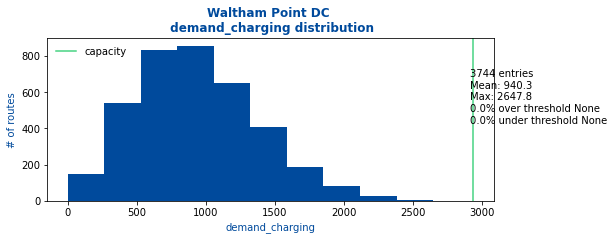

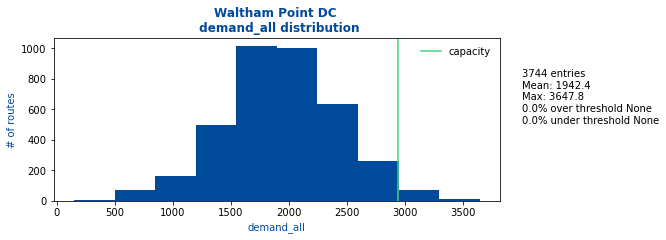

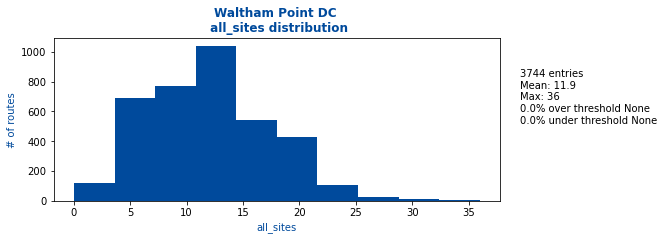

In [75]:
site_dict = get_site_name_dict(2)
histo_variable(demand, 'demand_charging', site_dict, site=1, upperclip=None,
               lowerclip=None, bins=10, suff='',
               vline_dict={'capacity': 3000*0.98}, title_text=None)
histo_variable(demand, 'demand_all', site_dict, site=1, upperclip=None,
               lowerclip=None, bins=10, suff='',
               vline_dict={'capacity': 3000*0.98}, title_text=None)
histo_variable(n_charging_all, 'all_sites', site_dict, site=1, upperclip=None,
               lowerclip=None, bins=10, suff='',
               vline_dict=None, title_text=None)

In [124]:
# scenarios = pd.concat([scenarios, demand[good_scenarios].max().rename('max_load_kw')], axis=1)
scenarios['max_load_kva'] = scenarios['max_load_kw']/0.98
cols = ['charger1', 'charger2', 'num_charger1', 'num_charger2', 'total_vehicles',
        'max_load_kw', 'max_load_kva', 'vehicle_model']
cols2 = ['vehicle_model', 'max_load_kva']
scenarios.loc[good_scenarios, cols2]

,vehicle_model,max_load_kva
scenario_id,,
510,Rigid 4x2,355.170909
511,Rigid 6x2,691.347991
512,Tractor 4x2,932.717345
513,Tractor 6x2,2048.582444
516,Tractor 4x2 5 pack,1234.567179
517,Tractor 4x2 4 pack,1391.222350


In [2]:
demand['time'] = ((demand.index - dt.datetime(2022, 1, 1)).total_seconds()/3600) % 24
demand_bytime = demand.groupby('time').max()

NameError: name 'demand' is not defined

### Combined load

In [162]:
site = 1
# connection, cur = dbh.database_connection('test')

# Load all charger data
cnx = dbh.create_alch_engine()
scenarios = (510, 511, 512, 513, 516, 517)
start_peak_date = dt.datetime(2022, 3, 28)
end_peak_date = dt.datetime(2022, 4, 25)
sql_query = f"""SELECT datetime, allocated_vehicle_id, power_demand_kw, scenario_id
    FROM t_charge_demand WHERE scenario_id IN {scenarios}
    AND datetime >= '{start_peak_date}' AND datetime < '{end_peak_date}'
    """
charging_demand = pd.read_sql_query(sql_query, con=cnx)
# Load site meter data
start_peak_date = dt.datetime(2021, 8, 30)
end_peak_date = dt.datetime(2021, 9, 27)
sql_query = f"""SELECT datetime, main_load_clean, total_solar_load_raw FROM t_site_load_meter_breakdown WHERE site_id={1}
    AND datetime >= '{start_peak_date}' AND datetime < '{end_peak_date}' ORDER BY datetime"""
load_data = pd.read_sql_query(sql_query, con=cnx, index_col='datetime')
# Get ASC values
asc_site = get_asc(site, connection, cur)
# Get charger data
sql_query = f"""SELECT scenario_id, charger1, charger2, num_charger1, num_charger2
    FROM t_charging_scenarios WHERE scenario_id IN {scenarios}"""
scenario_table = pd.read_sql_query(sql_query, con=cnx, index_col='scenario_id')
# mask_combined = charging_demand['scenario_id'].isin([510, 511, 517, 513])
# combined_site_demand = charging_demand[mask_combined].groupby('datetime').agg({
#     'power_demand_kw': 'sum',
# })
# combined_site_demand['week'] = combined_site_demand.index.isocalendar().week

In [168]:
# Group total charging demand per time period
charging_demand_site = charging_demand.groupby(['scenario_id', 'datetime'])[['power_demand_kw']].sum().reset_index()
charging_demand_site.sort_values(by=['scenario_id', 'datetime'], inplace=True)
charging_demand_site['site_load'] = np.tile(load_data['main_load_clean'], 6)
charging_demand_site['solar_load'] = np.tile(-load_data['total_solar_load_raw'], 6)
charging_demand_site['total_site_demand'] = charging_demand_site['power_demand_kw'] + charging_demand_site['site_load']
# Calculate max demand for each scenario
max_demand = charging_demand_site.groupby('scenario_id').max()
# For any scenarios that breach 90% of ASC, calculate by how much
max_demand['breach'] = max_demand['total_site_demand'] > asc_site * ASC_XUSE
max_demand['over_capacity'] = (max_demand['total_site_demand'] - asc_site * ASC_XUSE).clip(lower=0)
# Calculate how many chargers must be removed to stay under 90% ASC
max_demand = max_demand.merge(scenario_table, left_index=True, right_index=True, how='left')
max_demand['count_excess_chargers'] = max_demand['over_capacity'] / max_demand['charger1']
# Calculate demand combining 4 vehicle groups
mask_combined = charging_demand_site['scenario_id'].isin([510, 511, 517, 513])
combined_site_demand = charging_demand_site[mask_combined].groupby('datetime').agg({
    'power_demand_kw': 'sum',
    'site_load': 'mean',
    'solar_load': 'mean'
})
combined_site_demand['total_site_demand_kw'] = combined_site_demand['power_demand_kw'] + combined_site_demand['site_load']
combined_site_demand[['power_demand_kw', 'site_load', 'total_site_demand_kw']].max() / 0.98


power_demand_kw         2801.985867
site_load               2119.591837
total_site_demand_kw    4210.541829
dtype: float64

In [160]:
max_demand['num_ev'] = max_demand['num_charger1'] + max_demand['num_charger2']
max_demand[['count_excess_chargers', 'num_ev']].round(0)

,count_excess_chargers,num_ev
scenario_id,,
510,0.0,8
511,0.0,8
512,1.0,41
513,21.0,69
516,7.0,41
517,8.0,40


In [176]:
start_period = dt.datetime(2022, 4, 21)
duration = dt.timedelta(days=1)
mask_time = (combined_site_demand.index >= start_period) & (combined_site_demand.index < start_period + duration)
combined_site_demand[mask_time].head()

,power_demand_kw,site_load,solar_load,total_site_demand_kw
datetime,,,,
2022-04-21 00:00:00,485.163982,1454.1,0.0,1939.263982
2022-04-21 00:30:00,508.536548,1431.9,0.0,1940.436548
2022-04-21 01:00:00,796.546585,1366.3,0.0,2162.846585
2022-04-21 01:30:00,1045.879299,1354.8,0.0,2400.679299
2022-04-21 02:00:00,931.485061,1391.5,0.0,2322.985061


In [210]:
# Make a plot of combined demand (with the 4 pack)

def plot_site_loads(demand, site_name, asc, suff='', ):
    fig, ax = plt.subplots(
        1, figsize=(8, 3), gridspec_kw={'hspace': 0.5})
    ax.set_title(
        f'Sample Power Demand in {site_name}',
        color=FPS_COLOURS[0], fontweight='bold')
    ax.fill_between(
        demand.index,
        demand['site_load'],
        color=FPS_COLOURS[0], label='Site load', linewidth=0)
    ax.fill_between(
        demand.index,
        demand['total_site_demand_kw'], demand['site_load'],
        color=FPS_COLOURS[1], label='Charging load', linewidth=0)
    ax.fill(
        demand.index,
        demand['solar_load'],
        color=FPS_COLOURS[2], label='Solar', linewidth=0)

    ax.legend(frameon=False, bbox_to_anchor=(1, 1))
    ax.set_ylabel('Demand (kW)', color=FPS_COLOURS[0])
    ax.set_xlabel('Time', color=FPS_COLOURS[0])
    myFmt = matplotlib.dates.DateFormatter("%I%p")
    ax.xaxis.set_major_formatter(myFmt)
    ax.axhline(y=asc, label='ASC',
                color='black', ls='--')
    fig.savefig(
        f"sample/hgv2/{site_name}_demand{suff}.png",
        bbox_inches="tight", dpi=300)
    return

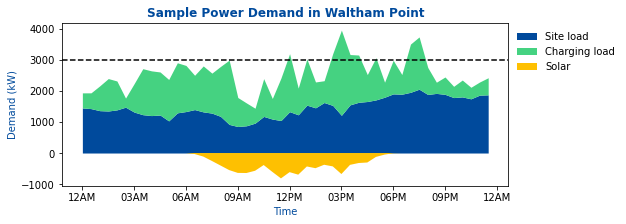

In [211]:
plot_site_loads(combined_site_demand[mask_time], 'Waltham Point', 3000, suff='', )

### All route distance

In [ ]:
cnx = dbh.create_alch_engine()
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
allroutes = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
allroutes['spec_id'] = allroutes['vehicle_id'].map(vehicle_spec_dict)
allroutes['date'] = allroutes['departure_time'].dt.date
allroutes = allroutes[allroutes['spec_id'] == 104]
vehicle_distance = allroutes.groupby('vehicle_id').agg({
    'distance_miles': 'sum',
    'date': 'nunique'
})
vehicle_distance['annual_distance'] = vehicle_distance['distance_miles'] * 365 / vehicle_distance['date']
vehicle_distance.mean()